In [113]:
import numpy as np
from blip_cbm import LitBlipViT
from dataset import LitAwA2DM, AwA2Dataset
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [114]:
ds = AwA2Dataset(root_dir='/home/andrewbai/data/', split='valid')
ds.class_names

array(['antelope', 'grizzly+bear', 'killer+whale', 'beaver', 'dalmatian',
       'persian+cat', 'horse', 'german+shepherd', 'blue+whale',
       'siamese+cat', 'skunk', 'mole', 'tiger', 'hippopotamus', 'leopard',
       'moose', 'spider+monkey', 'humpback+whale', 'elephant', 'gorilla',
       'ox', 'fox', 'sheep', 'seal', 'chimpanzee', 'hamster', 'squirrel',
       'rhinoceros', 'rabbit', 'bat', 'giraffe', 'wolf', 'chihuahua',
       'rat', 'weasel', 'otter', 'buffalo', 'zebra', 'giant+panda',
       'deer', 'bobcat', 'pig', 'lion', 'mouse', 'polar+bear', 'collie',
       'walrus', 'raccoon', 'cow', 'dolphin'], dtype='<U15')

In [2]:
model = LitBlipViT.load_checkpoint_as_model('./lightning_logs/AwA2_CBM/blip_vit/checkpoints/last.ckpt')

/home/andrewbai/miniconda3/envs/hf_new/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:255: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['loss_y.weight']
  rank_zero_warn(


In [99]:
valid_embs = np.load('./embeddings/blip_awa2-valid.npy')
valid_embs.shape

(7481, 577, 768)

In [100]:
valid_cls_embs = valid_embs[:, 0]
valid_cls_embs.shape

(7481, 768)

In [97]:
valid_cls_grads = np.load('./gradients/blip-vit_awa2-valid.npy')
valid_cls_grads.shape

(7481, 768)

In [115]:
cluster_embs = np.load('./embeddings/blip_awa2-valid_centroids-nc768.npy')
cluster_embs.shape

(768, 768)

In [117]:
with open('./embeddings/blip_awa2-valid_centroids-nc768.txt') as f:
    cluster_nls = np.array([line.strip() for line in f.readlines()])
len(cluster_nls)

768

In [118]:
class_weights = model.classification.weight.detach().numpy()
class_weights.shape

(50, 768)

In [119]:
valid_cls_embs[i, 0].shape

()

In [120]:
def visualize(i, topk=5):
    plt.imshow(ds[i][0])
    plt.axis('off')
    plt.show()
    pred_y = cosine_similarity(np.expand_dims(valid_cls_embs[i], 0), class_weights)[0]
    cls_proj_cluster = cosine_similarity(np.expand_dims(valid_cls_embs[i], 0), cluster_embs)[0]
    grad_proj_cluster = cosine_similarity(np.expand_dims(valid_cls_grads[i], 0), cluster_embs)[0]
    pred_proj_cluster = cosine_similarity(class_weights, cluster_embs)

    print(f"top {topk} pred class:", ds.class_names[(-pred_y).argsort()][:topk])

    print(f"top {topk} matched clusters of [CLS]:")

    for j in (-cls_proj_cluster).argsort()[:topk]:
        print('\t', cls_proj_cluster[j], cluster_nls[j])

    print(f"top {topk} matched clusters of class weights ({ds.class_names[pred_y.argmax()]}):")

    for j in (-pred_proj_cluster[pred_y.argmax()]).argsort()[:topk]:
        print('\t', pred_proj_cluster[pred_y.argmax()][j], cluster_nls[j])
        
    print(f"top {topk} matched clusters of CLS X class weights ({ds.class_names[pred_y.argmax()]}):")

    cls_prod_class = pred_proj_cluster[pred_y.argmax()] * cls_proj_cluster
    for j in (-cls_prod_class).argsort()[:topk]:
        print('\t', cls_prod_class[j], cluster_nls[j])
    
    print(f"top {topk} matched clusters of grads:")

    for j in (-grad_proj_cluster).argsort()[:topk]:
        print('\t', grad_proj_cluster[j], cluster_nls[j])
        
    print(f"top {topk} matched clusters of CLS X grads:")

    cls_prod_grad = grad_proj_cluster * cls_proj_cluster
    for j in (-cls_prod_grad).argsort()[:topk]:
        print('\t', cls_prod_grad[j], cluster_nls[j])

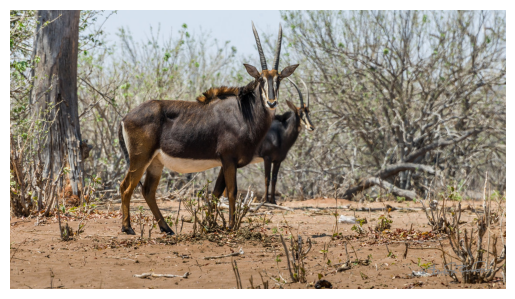

top 5 pred class: ['antelope' 'deer' 'zebra' 'ox' 'raccoon']
top 5 matched clusters of [CLS]:
	 0.8311004 the - - - -
	 0.23800646 a old old old old
	 0.23720178 a a a a a
	 0.23661833 a a hanging hanging hanging
	 0.23545073 a wet wet wet wet
top 5 matched clusters of class weights (antelope):
	 0.12962848 deer deer deer deer deer
	 0.11888186 a deer deer deer deer
	 0.11256918 deer deer deer deer deer
	 0.112313636 grazing grazing grazing grazing grazing
	 0.105972685 gi gi gi gi gi
top 5 matched clusters of CLS X class weights (antelope):
	 0.020095007 gi gi gi gi gi
	 0.018162044 a deer deer deer deer
	 0.017056463 deer deer deer deer deer
	 0.016355483 grazing grazing grazing grazing grazing
	 0.016027 zebra zebra zebra zebra zebra
top 5 matched clusters of grads:
	 0.07581868 laughing laughing laughing laughing laughing
	 0.075180955 rhino rhino rhino rhino rhino
	 0.075144336 two baby baby baby baby
	 0.07476977 rhino rhino rhino rhino rhino
	 0.068840556 a dog dog dog dog
top 5

In [121]:
visualize(0)

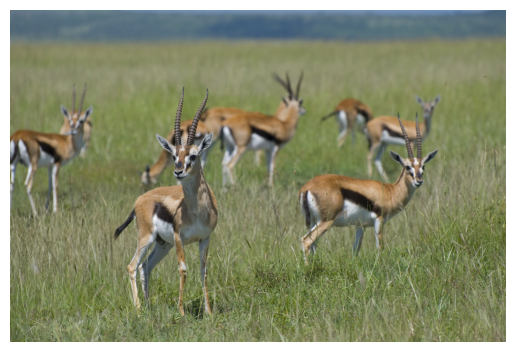

top 5 pred class: ['antelope' 'deer' 'zebra' 'dolphin' 'giraffe']
top 5 matched clusters of [CLS]:
	 0.7731043 the - - - -
	 0.24098471 a old old old old
	 0.23547673 a small small small small
	 0.22857797 a hand hand hand hand
	 0.2257599 a wet wet wet wet
top 5 matched clusters of class weights (antelope):
	 0.12962848 deer deer deer deer deer
	 0.11888186 a deer deer deer deer
	 0.11256918 deer deer deer deer deer
	 0.112313636 grazing grazing grazing grazing grazing
	 0.105972685 gi gi gi gi gi
top 5 matched clusters of CLS X class weights (antelope):
	 0.02297056 deer deer deer deer deer
	 0.019064084 a deer deer deer deer
	 0.01754756 gi gi gi gi gi
	 0.016914781 a deer deer deer deer
	 0.016274977 grazing grazing grazing grazing grazing
top 5 matched clusters of grads:
	 0.07581672 laughing laughing laughing laughing laughing
	 0.075240865 rhino rhino rhino rhino rhino
	 0.07517871 two baby baby baby baby
	 0.074832276 rhino rhino rhino rhino rhino
	 0.068770066 a dog dog dog do

In [122]:
visualize(100)

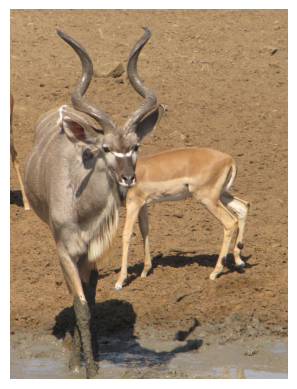

top 5 pred class: ['antelope' 'deer' 'otter' 'ox' 'dolphin']
top 5 matched clusters of [CLS]:
	 0.8245926 the - - - -
	 0.23402822 a small small small small
	 0.22544341 a old old old old
	 0.22481707 a a hanging hanging hanging
	 0.22433364 a wet wet wet wet
top 5 matched clusters of class weights (antelope):
	 0.12962848 deer deer deer deer deer
	 0.11888186 a deer deer deer deer
	 0.11256918 deer deer deer deer deer
	 0.112313636 grazing grazing grazing grazing grazing
	 0.105972685 gi gi gi gi gi
top 5 matched clusters of CLS X class weights (antelope):
	 0.016019214 gi gi gi gi gi
	 0.015338354 a deer deer deer deer
	 0.01458176 grazing grazing grazing grazing grazing
	 0.01378628 a ears ears ears ears
	 0.013492111 deer deer deer deer deer
top 5 matched clusters of grads:
	 0.081218824 rhino rhino rhino rhino rhino
	 0.08082084 two baby baby baby baby
	 0.07616104 laughing laughing laughing laughing laughing
	 0.07605473 rhino rhino rhino rhino rhino
	 0.074043915 a dog dog dog d

In [123]:
visualize(200)

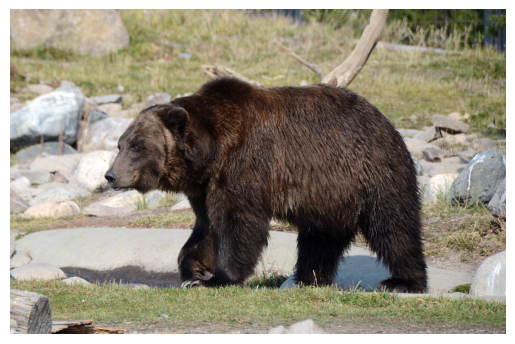

top 5 pred class: ['grizzly+bear' 'polar+bear' 'ox' 'buffalo' 'wolf']
top 5 matched clusters of [CLS]:
	 0.7170595 the - - - -
	 0.2510345 a a hanging hanging hanging
	 0.23882651 a a a a a
	 0.23679341 a old old old old
	 0.23256999 a small small small small
top 5 matched clusters of class weights (grizzly+bear):
	 0.16000338 a bear bear bear bear
	 0.15741855 gr brown brown brown brown
	 0.14050362 a brown brown brown brown
	 0.13301516 a bear bear bear bear
	 0.1143681 a a a a a
top 5 matched clusters of CLS X class weights (grizzly+bear):
	 0.028399894 a bear bear bear bear
	 0.027033135 a bear bear bear bear
	 0.026798991 a brown brown brown brown
	 0.024273405 a a a a a
	 0.021540819 gr brown brown brown brown
top 5 matched clusters of grads:
	 1.0903802e-08 a a a a a
	 9.847862e-09 a trash trash trash trash
	 9.8427115e-09 a pasture pasture pasture pasture
	 9.836514e-09 a messy messy messy messy
	 9.833573e-09 a old old old old
top 5 matched clusters of CLS X grads:
	 5.476258e

In [124]:
visualize(300)

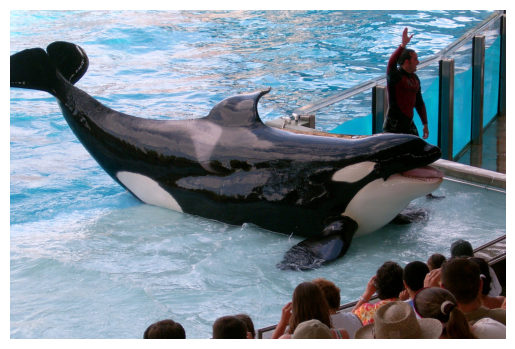

top 5 pred class: ['killer+whale' 'dolphin' 'humpback+whale' 'gorilla' 'seal']
top 5 matched clusters of [CLS]:
	 0.743047 the - - - -
	 0.29264158 dolphin dolphin dolphin dolphin dolphin
	 0.26113164 a black black black black
	 0.25989738 a small small small small
	 0.2549066 a black black black black
top 5 matched clusters of class weights (killer+whale):
	 0.05554312 a whale whale whale whale
	 0.055097565 a - - - -
	 0.053658225 carpet carpet carpet carpet carpet
	 0.051581077 a boat boat boat boat
	 0.050892483 horse horse horse horse horse
top 5 matched clusters of CLS X class weights (killer+whale):
	 0.014793256 dolphin dolphin dolphin dolphin dolphin
	 0.013177347 a whale whale whale whale
	 0.010325663 dolphins dolphins dolphins dolphins dolphins
	 0.009162795 a boat boat boat boat
	 0.008455129 or or or or or
top 5 matched clusters of grads:
	 0.08999176 a - - - -
	 0.063304104 a digital digital digital digital
	 0.057646 a pig pig pig pig
	 0.057192564 a inside inside insid

In [125]:
visualize(400)

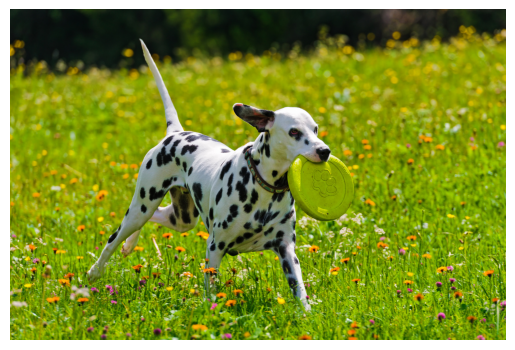

top 5 pred class: ['dalmatian' 'collie' 'chihuahua' 'cow' 'siamese+cat']
top 5 matched clusters of [CLS]:
	 0.7366683 the - - - -
	 0.28770265 a small small small small
	 0.28747272 a old old old old
	 0.2853617 a black black black black
	 0.28321746 a black black black black
top 5 matched clusters of class weights (dalmatian):
	 0.14439102 dal dal dal dal dal
	 0.12814203 a dog dog dog dog
	 0.067369536 a a a a stuffed
	 0.06047219 a dog dog dog dog
	 0.06044447 black black black black black
top 5 matched clusters of CLS X class weights (dalmatian):
	 0.0194549 dal dal dal dal dal
	 0.018444669 a dog dog dog dog
	 0.016440948 a a a a stuffed
	 0.014644051 a dog dog dog dog
	 0.011715669 a a a a a
top 5 matched clusters of grads:
	 1.942282e-08 a woman in a white
	 1.9357767e-08 a woman in a white
	 1.9355546e-08 a woman in a white
	 1.934892e-08 a woman in a white
	 1.9341464e-08 a woman in a white
top 5 matched clusters of CLS X grads:
	 1.0663577e-08 the - - - -
	 2.5341829e-09 the 

In [126]:
visualize(500)

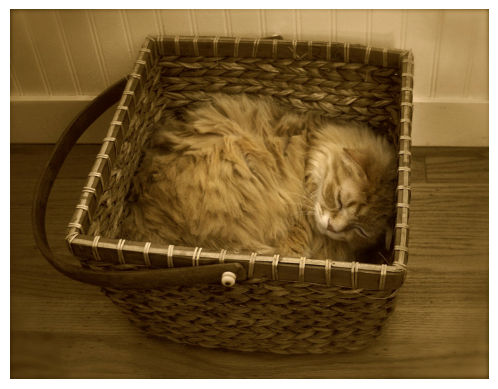

top 5 pred class: ['persian+cat' 'siamese+cat' 'chimpanzee' 'hamster' 'mouse']
top 5 matched clusters of [CLS]:
	 0.6969515 the - - - -
	 0.2136784 a cat cat cat cat
	 0.21322295 a a a a a
	 0.20804365 a a a a a
	 0.1961563 a a a a a
top 5 matched clusters of class weights (persian+cat):
	 0.104703136 a cat cat cat cat
	 0.10054016 a cat cat cat cat
	 0.099947974 a a a a a
	 0.098120034 a a a cat cat
	 0.08031091 a a a a a
top 5 matched clusters of CLS X class weights (persian+cat):
	 0.01666175 a a a a a
	 0.015201532 a a a a a
	 0.014453183 a cat cat cat cat
	 0.014101404 a a a a a
	 0.013330464 a a the the the
top 5 matched clusters of grads:
	 0.08433544 a rope rope rope rope
	 0.077743866 two two two two two
	 0.076401114 road road road road road
	 0.07620978 a cat cat cat cat
	 0.07516999 fence fence fence fence fence
top 5 matched clusters of CLS X grads:
	 0.013101091 a plastic plastic plastic plastic
	 0.01240295 a cat cat cat cat
	 0.012150561 a a a a a
	 0.012026223 a table 

In [127]:
visualize(600)

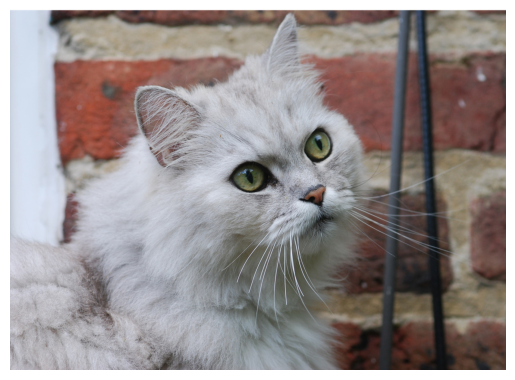

top 5 pred class: ['persian+cat' 'sheep' 'siamese+cat' 'lion' 'fox']
top 5 matched clusters of [CLS]:
	 0.7733495 the - - - -
	 0.21534364 a cat cat cat cat
	 0.19640353 a a a a a
	 0.19563976 a a hanging hanging hanging
	 0.19187689 a small small small small
top 5 matched clusters of class weights (persian+cat):
	 0.104703136 a cat cat cat cat
	 0.10054016 a cat cat cat cat
	 0.099947974 a a a a a
	 0.098120034 a a a cat cat
	 0.08031091 a a a a a
top 5 matched clusters of CLS X class weights (persian+cat):
	 0.018191755 a a a cat cat
	 0.01456582 a cat cat cat cat
	 0.013941808 a cat cat cat cat
	 0.0119543215 a a a a a
	 0.0116634695 a a a a a
top 5 matched clusters of grads:
	 9.299665e-09 the - - - -
	 8.721344e-09 hip hip hip hip hip
	 7.775503e-09 christmas christmas christmas christmas christmas
	 7.509785e-09 hip hip hip hip hip
	 6.5150054e-09 stuffed stuffed stuffed stuffed stuffed
top 5 matched clusters of CLS X grads:
	 7.1918915e-09 the - - - -
	 9.443606e-10 plant plant 

In [128]:
visualize(700)

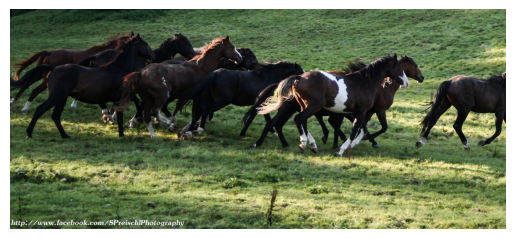

top 5 pred class: ['horse' 'collie' 'cow' 'persian+cat' 'antelope']
top 5 matched clusters of [CLS]:
	 0.80089104 the - - - -
	 0.26045275 a small small small small
	 0.2570569 a black black black black
	 0.25696906 a black black black black
	 0.2482887 a wet wet wet wet
top 5 matched clusters of class weights (horse):
	 0.15860425 a horse horse horse horse
	 0.15051608 horse horse horse horse horse
	 0.13809922 horse horse horse horse horse
	 0.13721278 a horse horse horse horse
	 0.13310888 a pony pony pony pony
top 5 matched clusters of CLS X class weights (horse):
	 0.025700195 a horse horse horse horse
	 0.021955147 horse jockey jockey jockey jockey
	 0.019626385 a horse horse horse horse
	 0.018619107 a pony pony pony pony
	 0.018475821 horse horse horse horse horse
top 5 matched clusters of grads:
	 0.13289419 horse horse horse horse horse
	 0.12993197 horse horse horse horse horse
	 0.12061222 a horse horse horse horse
	 0.11967179 a horse horse horse horse
	 0.11018203 horse h

In [129]:
visualize(1000)

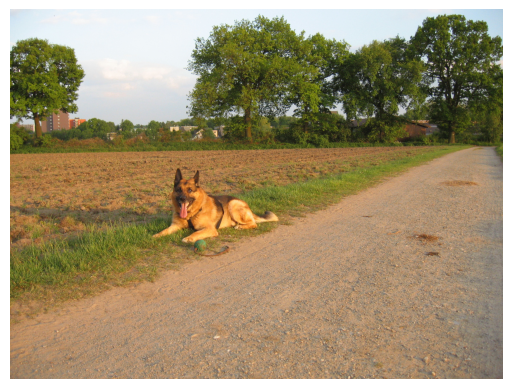

top 5 pred class: ['german+shepherd' 'collie' 'cow' 'horse' 'moose']
top 5 matched clusters of [CLS]:
	 0.782464 the - - - -
	 0.2329736 a black black black black
	 0.22853191 a a hanging hanging hanging
	 0.22672595 a pig pig pig pig
	 0.22592455 a black black black black
top 5 matched clusters of class weights (german+shepherd):
	 0.11052537 a german german german german
	 0.08479365 road road road road road
	 0.08478364 a dog dog dog dog
	 0.08326365 gravel gravel gravel gravel gravel
	 0.08071617 a dog dog dog dog
top 5 matched clusters of CLS X class weights (german+shepherd):
	 0.011790972 road road road road road
	 0.011496877 snow snow snow snow snow
	 0.011438945 a blanket blanket blanket blanket
	 0.010348091 gravel gravel gravel gravel gravel
	 0.010179741 a white and black photo
top 5 matched clusters of grads:
	 0.0668799 gravel gravel gravel gravel gravel
	 0.06057837 ya ya ya ya ya
	 0.05979447 two baby baby baby baby
	 0.059675787 a german german german german
	 0.05902

In [130]:
visualize(1100)

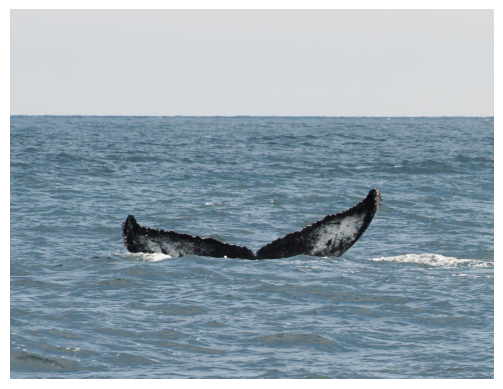

top 5 pred class: ['blue+whale' 'humpback+whale' 'killer+whale' 'cow' 'walrus']
top 5 matched clusters of [CLS]:
	 0.78425914 the - - - -
	 0.23386598 a black black black black
	 0.22791618 a pig pig pig pig
	 0.22446018 a whale whale whale whale
	 0.22256748 a a a a a
top 5 matched clusters of class weights (blue+whale):
	 0.07894973 squirrel squirrel squirrel squirrel squirrel
	 0.07181266 squirrel squirrel squirrel squirrel squirrel
	 0.07064678 fence fence fence fence fence
	 0.065535635 a dolphin dolphin dolphin dolphin
	 0.063822664 a whale whale whale whale
top 5 matched clusters of CLS X class weights (blue+whale):
	 0.008164274 a whale whale whale whale
	 0.007877526 a whale whale whale whale
	 0.0076010176 fence fence fence fence fence
	 0.0070670783 a dolphin dolphin dolphin dolphin
	 0.007061875 a whale whale whale whale
top 5 matched clusters of grads:
	 0.08273101 leaves leaves leaves leaves leaves
	 0.081358686 leaves leaves leaves leaves leaves
	 0.07664381 sheep sheep 

In [131]:
visualize(1300)

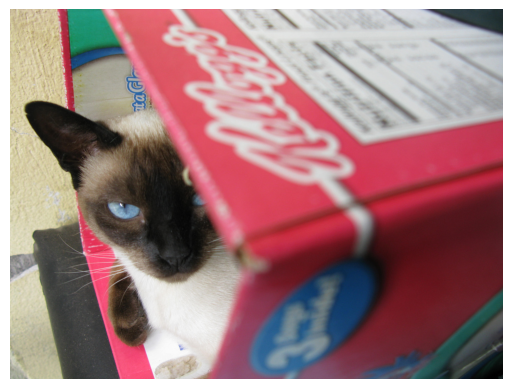

top 5 pred class: ['siamese+cat' 'persian+cat' 'cow' 'hamster' 'dolphin']
top 5 matched clusters of [CLS]:
	 0.7308785 the - - - -
	 0.19483474 a cat cat cat cat
	 0.18925522 a black black black black
	 0.18451166 a black black black black
	 0.18218291 a black black black black
top 5 matched clusters of class weights (siamese+cat):
	 0.10061516 siam siam siam siam siam
	 0.04859486 cat cat cat cat cat
	 0.044798747 a ant ant ant ant
	 0.04411671 a cat cat cat cat
	 0.04355949 deer deer deer deer deer
top 5 matched clusters of CLS X class weights (siamese+cat):
	 0.015792623 siam siam siam siam siam
	 0.006368869 a kitten kitten kitten kitten
	 0.0053765057 cat cat cat cat cat
	 0.0039287503 a cat cat cat cat
	 0.0038831863 a a a cat cat
top 5 matched clusters of grads:
	 0.08706488 panda panda panda panda panda
	 0.067098886 panda panda panda panda panda
	 0.06503881 deer deer deer deer deer
	 0.06488289 panda panda panda panda panda
	 0.0621901 holstein holstein holstein holstein hols

In [132]:
visualize(1400)

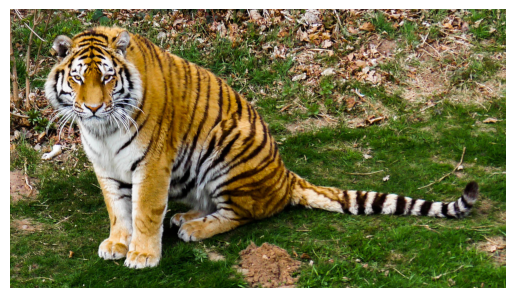

top 5 pred class: ['tiger' 'leopard' 'zebra' 'lion' 'squirrel']
top 5 matched clusters of [CLS]:
	 0.83726335 the - - - -
	 0.2608129 a a hanging hanging hanging
	 0.2536087 a small small small small
	 0.25243303 a a a a a
	 0.2501455 dolphin dolphin dolphin dolphin dolphin
top 5 matched clusters of class weights (tiger):
	 0.16426954 tiger tiger tiger tiger tiger
	 0.13316806 tiger tiger tiger tiger tiger
	 0.11898371 a tiger tiger tiger tiger
	 0.11832921 a lion lion lion lion
	 0.106787734 a a a a a
top 5 matched clusters of CLS X class weights (tiger):
	 0.025175923 tiger tiger tiger tiger tiger
	 0.020181604 a lion lion lion lion
	 0.018566724 tree tree tree tree tree
	 0.017913457 a a a a a
	 0.017533643 a tiger tiger tiger tiger
top 5 matched clusters of grads:
	 2.6560778e-09 chihuahua chihuahua chihuahua chihuahua chihuahua
	 2.5654852e-09 a pig pig pig pig
	 2.397246e-09 a puppy puppy puppy puppy
	 2.360069e-09 a hands hands hands hands
	 2.2888471e-09 a ra ra ra ra
top 5 mat

In [133]:
visualize(1500)

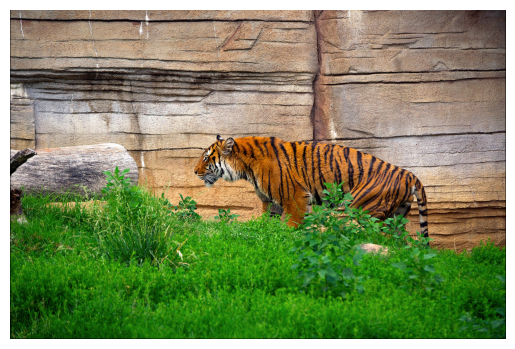

top 5 pred class: ['tiger' 'zebra' 'lion' 'grizzly+bear' 'hippopotamus']
top 5 matched clusters of [CLS]:
	 0.8213896 the - - - -
	 0.30075663 a small small small small
	 0.2981651 a black black black black
	 0.29788095 a black black black black
	 0.29579425 a a a a a
top 5 matched clusters of class weights (tiger):
	 0.16426954 tiger tiger tiger tiger tiger
	 0.13316806 tiger tiger tiger tiger tiger
	 0.11898371 a tiger tiger tiger tiger
	 0.11832921 a lion lion lion lion
	 0.106787734 a a a a a
top 5 matched clusters of CLS X class weights (tiger):
	 0.027162867 tiger tiger tiger tiger tiger
	 0.02401685 a tiger tiger tiger tiger
	 0.0239979 a lion lion lion lion
	 0.022424843 a a a a a
	 0.02067095 tree tree tree tree tree
top 5 matched clusters of grads:
	 1.5320094e-08 the - - - -
	 8.555255e-09 chihuahua chihuahua chihuahua chihuahua chihuahua
	 8.210029e-09 mouse mouse mouse mouse mouse
	 8.031719e-09 siam siam siam siam siam
	 7.180132e-09 a ham ham ham ham
top 5 matched cluste

In [134]:
visualize(1600)

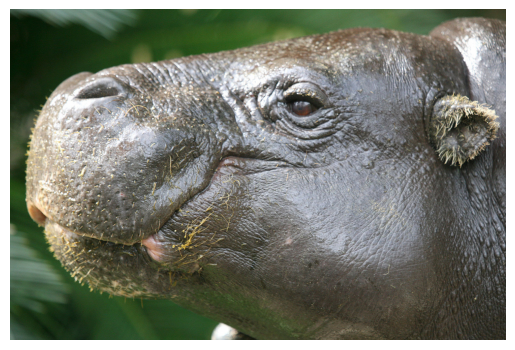

top 5 pred class: ['hippopotamus' 'gorilla' 'chimpanzee' 'rhinoceros' 'seal']
top 5 matched clusters of [CLS]:
	 0.82469106 the - - - -
	 0.22616301 a a hanging hanging hanging
	 0.22206607 hip hip hip hip hip
	 0.21922688 a small small small small
	 0.21581358 a elephant elephant elephant elephant
top 5 matched clusters of class weights (hippopotamus):
	 0.10158984 hip hip hip hip hip
	 0.08913192 hip hip hip hip hip
	 0.06155123 a close close close close
	 0.060063347 a gorilla gorilla gorilla gorilla
	 0.05838347 water water water water water
top 5 matched clusters of CLS X class weights (hippopotamus):
	 0.022559658 hip hip hip hip hip
	 0.015433024 hip hip hip hip hip
	 0.009013361 a close close close close
	 0.008450992 a gorilla gorilla gorilla gorilla
	 0.008097402 a elephant elephant elephant elephant
top 5 matched clusters of grads:
	 0.08944588 hip hip hip hip hip
	 0.06876559 hip hip hip hip hip
	 0.06827255 a a a a a
	 0.06316555 stone stone stone stone stone
	 0.05872537 

In [135]:
visualize(1700)

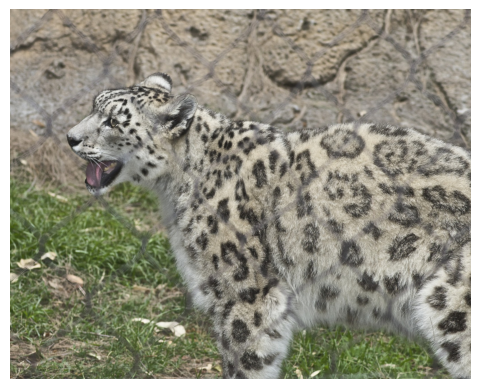

top 5 pred class: ['leopard' 'bobcat' 'seal' 'dalmatian' 'wolf']
top 5 matched clusters of [CLS]:
	 0.7732553 the - - - -
	 0.2495059 a small small small small
	 0.23990679 a a a a a
	 0.23957773 a a a a a
	 0.23861368 dolphin dolphin dolphin dolphin dolphin
top 5 matched clusters of class weights (leopard):
	 0.10299116 snow snow snow snow snow
	 0.0901773 leopard leopard leopard leopard leopard
	 0.08000252 wooden deck deck deck deck
	 0.078047186 a a a a a
	 0.07693897 a a a a a
top 5 matched clusters of CLS X class weights (leopard):
	 0.018138979 snow snow snow snow snow
	 0.016519397 a a a a a
	 0.014137013 christmas christmas christmas christmas christmas
	 0.0134471925 boulders boulders boulders boulders boulders
	 0.013261728 a chair chair chair chair
top 5 matched clusters of grads:
	 1.7484851e-08 a ears ears ears ears
	 1.611346e-08 a a a a a
	 1.5960232e-08 a pig pig pig pig
	 1.5899616e-08 a white white white white
	 1.5706405e-08 a whale whale whale whale
top 5 matched c

In [136]:
visualize(1800)

#### Next steps:
* increase number of clusters and improve pruning
    * manually prune clusters with non-human-understadable text
    * prune clusters that are too generic?
    * what is a useful cluster?
* make interpretation ``discriminative'' &rarr; use input gradient instead of class weights
* establish baseline of predicting based on inner-product project into the concept space (feels like factorization machine)
* Cho
    * currently using class weights only decodes into "this is some particular animal", can we make the explanation more discriminative?
    * maybe use harder dataset
    
* purpose cluster is to have decodable basis. other methods of finding decodable basis?
    * back to ADDA?
    * prompt LM to generate descriptions of the image patches

granularity control 
* concept shared between class to lower semantic meaning (e.g. stripes instead of tiger)
* shallower layer image patches
    * lower-level semantic meaning?
    * decodable?
    
description naturalness
* does larger patch lead to more "colloquial" decodings?
* restricted by pretrained dataset?
    * solvable by prompt?
    * fundementally switch model that is trained on "general" dataset (insetad of merely captioning)

directly decode input gradients wrt the whole ViT output embedding

learning a decodable mapping?

verify if some metric of these undecodable samples are abnormally (discriminitively) high

establish baseline of directly matching (a ton of) sentences with input